In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import math
from utils import *
import talib as tl
%matplotlib inline

In [2]:
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn_pandas import DataFrameMapper

In [3]:
data = read_ami_SPY_data()

In [4]:
def llen(col, data=data):
    return len(data[data[col]])

In [5]:
data.head(5)

,Open,High,Low,Close,Volume
Date,,,,,
1999-03-10,128.4687,129.2500,127.7812,129.1875,3950000
1999-03-11,129.6875,131.1875,128.8750,130.6250,6583700
1999-03-12,131.0000,131.0312,129.2187,129.3750,5286500
1999-03-15,129.9375,131.2500,129.5000,131.2187,5394400
1999-03-16,131.1250,131.6562,130.4687,130.7187,4547500


In [6]:
O = data['Open']
H = data['High']
L = data['Low']
C = data['Close']
V = data['Volume']

In [7]:
data['Weekday'] = data.index.dayofweek.map(lambda x: {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri'}.get(x))

In [8]:
data['Month'] = data.index.month

In [9]:
data[['Weekday', 'Month']].head()

,Weekday,Month
Date,,
1999-03-10,Wed,3
1999-03-11,Thu,3
1999-03-12,Fri,3
1999-03-15,Mon,3
1999-03-16,Tue,3


In [10]:
def binarize_column(data, col):
    mapper = DataFrameMapper([(col, LabelBinarizer())], df_out=True, default=None)
    data = mapper.fit_transform(data)
    return data

In [11]:
data['Last trading day of month'] = np.append((data[:-1].index.day > data[1:].index.day), False)

In [12]:
data['First trading day of month'] = np.insert((data[1:].index.day < data[:-1].index.day), 0, False)

In [13]:
data['End of Quarter'] = (data['Month'] % 3 == 0) & data['Last trading day of month']
data[data['End of Quarter']].index

DatetimeIndex(['1999-03-31', '1999-06-30', '1999-09-30', '1999-12-31',
               '2000-03-31', '2000-06-30', '2000-09-29', '2000-12-29',
               '2001-03-30', '2001-06-29', '2001-09-28', '2001-12-31',
               '2002-03-28', '2002-06-28', '2002-09-30', '2002-12-31',
               '2003-03-31', '2003-06-30', '2003-09-30', '2003-12-31',
               '2004-03-31', '2004-06-30', '2004-09-30', '2004-12-31',
               '2005-03-31', '2005-06-30', '2005-09-30', '2005-12-30',
               '2006-03-31', '2006-06-30', '2006-09-29', '2006-12-29',
               '2007-03-30', '2007-06-29', '2007-09-28', '2007-12-31',
               '2008-03-31', '2008-06-30', '2008-09-30', '2008-12-31',
               '2009-03-31', '2009-06-30', '2009-09-30', '2009-12-31',
               '2010-03-31', '2010-06-30', '2010-09-30', '2010-12-31',
               '2011-03-31', '2011-06-30', '2011-09-30', '2011-12-30',
               '2012-03-30', '2012-06-29', '2012-09-28', '2012-12-31',
      

In [14]:
data['Closes down 1d'] = C < C.shift()

In [15]:
data['Closes up in a row 2d'] = (C > C.shift()).rolling(2).mean() == 1
data['Closes up in a row 3d'] = (C > C.shift()).rolling(3).mean() == 1
data['Closes up in a row 4d'] = (C > C.shift()).rolling(4).mean() == 1
data['Closes up in a row 5d'] = (C > C.shift()).rolling(5).mean() == 1
data['Closes up in a row 5d S(1d)'] = data['Closes up in a row 5d'].shift().fillna(False)

data['Closes down in a row 2d'] = (C < C.shift()).rolling(2).mean() == 1
data['Closes down in a row 3d'] = (C < C.shift()).rolling(3).mean() == 1
data['Closes down in a row 4d'] = (C < C.shift()).rolling(4).mean() == 1
data['Closes down in a row 5d'] = (C < C.shift()).rolling(5).mean() == 1

In [16]:
data[['Close', 'Closes down 1d', 'Closes down in a row 2d']].head(10)

,Close,Closes down 1d,Closes down in a row 2d
Date,,,
1999-03-10,129.1875,False,False
1999-03-11,130.6250,False,False
1999-03-12,129.3750,True,False
1999-03-15,131.2187,False,False
1999-03-16,130.7187,True,False
1999-03-17,130.1562,True,True
1999-03-18,132.2500,False,False
1999-03-19,129.6875,True,False
1999-03-22,129.9375,False,False


In [17]:
data['1999-10-15':'1999-10-25'][['Close', 'Closes up in a row 5d S(1d)']]

,Close,Closes up in a row 5d S(1d)
Date,,
1999-10-15,124.8750,False
1999-10-18,125.7812,False
1999-10-19,127.0000,False
1999-10-20,128.2500,False
1999-10-21,129.0000,False
1999-10-22,130.0937,False
1999-10-25,129.4375,True


In [18]:
data['Day'] = data.index.day

In [19]:
data.head(2)

,Open,High,Low,Close,Volume,Weekday,Month,Last trading day of month,First trading day of month,End of Quarter,...,Closes up in a row 2d,Closes up in a row 3d,Closes up in a row 4d,Closes up in a row 5d,Closes up in a row 5d S(1d),Closes down in a row 2d,Closes down in a row 3d,Closes down in a row 4d,Closes down in a row 5d,Day
Date,,,,,,,,,,,,,,,,,,,,,
1999-03-10,128.4687,129.2500,127.7812,129.1875,3950000,Wed,3,False,False,False,...,False,False,False,False,False,False,False,False,False,10
1999-03-11,129.6875,131.1875,128.8750,130.6250,6583700,Thu,3,False,False,False,...,False,False,False,False,False,False,False,False,False,11


In [20]:
data['Daily return'] = C.pct_change().fillna(0)*100

In [21]:
data['Daily return'].head()

Date
1999-03-10    0.000000
1999-03-11    1.112724
1999-03-12   -0.956938
1999-03-15    1.425082
1999-03-16   -0.381043
Name: Daily return, dtype: float64

In [22]:
data['Lowest volume 5d'] = V.rolling(5).min() == V

In [23]:
data.head(10)[['Volume', 'Lowest volume 5d']]

,Volume,Lowest volume 5d
Date,,
1999-03-10,3950000,False
1999-03-11,6583700,False
1999-03-12,5286500,False
1999-03-15,5394400,False
1999-03-16,4547500,False
1999-03-17,4524100,True
1999-03-18,3506300,True
1999-03-19,5526700,False
1999-03-22,4603800,False


In [24]:
data['Daily return 5d'] = C.pct_change(5).fillna(0)*100

In [25]:
data[['Close', 'Daily return 5d']].head(6)

,Close,Daily return 5d
Date,,
1999-03-10,129.1875,0.00000
1999-03-11,130.6250,0.00000
1999-03-12,129.3750,0.00000
1999-03-15,131.2187,0.00000
1999-03-16,130.7187,0.00000
1999-03-17,130.1562,0.74984


In [26]:
data['OPEX week'] = (data['Day'] > 14) & (data['Day'] < 22)

In [27]:
data['Tomorrow is OPEX Friday'] = (data['Weekday'] == 'Thu') & data.shift()['OPEX week']

In [28]:
data['Today is OPEX Friday'] = (data['Weekday'] == 'Fri') & data['OPEX week']

In [29]:
data.iloc[6:9]

,Open,High,Low,Close,Volume,Weekday,Month,Last trading day of month,First trading day of month,End of Quarter,...,Closes down in a row 3d,Closes down in a row 4d,Closes down in a row 5d,Day,Daily return,Lowest volume 5d,Daily return 5d,OPEX week,Tomorrow is OPEX Friday,Today is OPEX Friday
Date,,,,,,,,,,,,,,,,,,,,,
1999-03-18,129.7812,132.3750,129.7500,132.2500,3506300,Thu,3,False,False,False,...,False,False,False,18,1.608682,True,1.244019,True,True,False
1999-03-19,132.3125,132.6250,129.6875,129.6875,5526700,Fri,3,False,False,False,...,False,False,False,19,-1.937618,False,0.241546,True,False,True
1999-03-22,130.0625,130.5937,129.4218,129.9375,4603800,Mon,3,False,False,False,...,False,False,False,22,0.192771,False,-0.976385,False,False,False


In [30]:
data['Before OPEX week'] = (data['Day'] > 7) & (data['Day'] < 15)

In [31]:
monthly_max = C.resample('M').max()
monthly_max.head()

Date
1999-03-31    132.2500
1999-04-30    137.2500
1999-05-31    137.3437
1999-06-30    137.0000
1999-07-31    141.8125
Freq: M, Name: Close, dtype: float64

In [32]:
monthly_max = monthly_max.resample(rule='1D', kind='timestamp').last().bfill()
monthly_max.head()

Date
1999-03-31    132.25
1999-04-01    137.25
1999-04-02    137.25
1999-04-03    137.25
1999-04-04    137.25
Freq: D, Name: Close, dtype: float64

In [33]:
data['Highest closing price of the month'] = data['Last trading day of month'] & (C == monthly_max[data.index])
data[data['Highest closing price of the month'] == True].head()

,Open,High,Low,Close,Volume,Weekday,Month,Last trading day of month,First trading day of month,End of Quarter,...,Closes down in a row 5d,Day,Daily return,Lowest volume 5d,Daily return 5d,OPEX week,Tomorrow is OPEX Friday,Today is OPEX Friday,Before OPEX week,Highest closing price of the month
Date,,,,,,,,,,,,,,,,,,,,,
1999-06-30,134.6250,137.5000,133.8437,137.0000,16856100,Wed,6,True,False,True,...,False,30,1.811426,False,2.983360,False,False,False,False,True
1999-10-29,135.8437,137.6875,135.7187,137.0000,10988600,Fri,10,True,False,False,...,False,29,1.811426,False,5.308712,False,False,False,False,True
1999-12-31,146.8437,147.5000,146.2500,146.8750,3172700,Fri,12,True,False,True,...,False,31,0.159847,False,0.266718,False,False,False,False,True
2000-08-31,151.0625,153.0937,150.9062,152.3437,4863100,Thu,8,True,False,False,...,False,31,1.330285,False,0.681504,False,False,False,False,True
2001-04-30,126.4500,127.2700,124.6700,126.6600,10766900,Mon,4,True,False,False,...,False,30,0.699634,False,3.615838,False,False,False,False,True


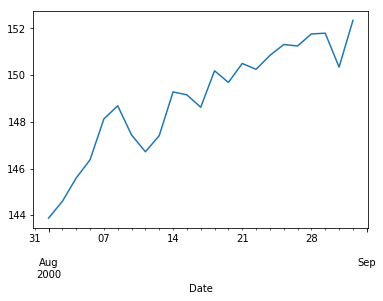

In [34]:
C['2000-08'].plot()

In [35]:
data['Daily return S(1d)'] = data['Daily return'].shift().fillna(0)
data['First trading day of month S(1d)'] = data['First trading day of month'].shift().fillna(False)
data[['First trading day of month', 'First trading day of month S(1d)', 'Daily return S(1d)']].iloc[15:18]

,First trading day of month,First trading day of month S(1d),Daily return S(1d)
Date,,,
1999-03-31,False,False,-0.524184
1999-04-01,True,False,-1.604753
1999-04-05,False,True,0.754586


In [36]:
D = data['Day']
W = data['Weekday']
M = data['Month']

In [37]:
data['Thursday before Labor Day'] = (W == 'Thu') & (((M == 8) & (D > 27)) | ((M == 9) & (D < 4)))

In [38]:
data['Friday before Labor Day'] = (W == 'Fri') & (((M == 8) & (D > 28)) | ((M == 9) & (D < 5)))

In [39]:
data['Friday before Columbus Day'] = (W == 'Fri') & (M == 10) & (D > 4) & (D < 12) 

In [40]:
data['Thursday before Pres Day'] = (W == 'Thu') & (M == 2) & (D > 10) & (D < 18) 

In [41]:
data['Closes high 4d'] = C.rolling(4).max() == C

In [42]:
data[['Closes high 4d', 'Close']].tail(10)

,Closes high 4d,Close
Date,,
2018-01-04,True,271.61
2018-01-05,True,273.42
2018-01-08,True,273.92
2018-01-09,True,274.54
2018-01-10,False,274.12
2018-01-11,True,276.12
2018-01-12,True,277.92
2018-01-16,False,276.97
2018-01-17,True,279.61


In [43]:
data['Closes low 5d'] = C.rolling(5).min() == C
data['Closes low 5d S(1d)'] = data['Closes low 5d'].shift().fillna(False)

In [44]:
data[data['Closes low 5d'] | data['Closes low 5d S(1d)']].head(4)

,Open,High,Low,Close,Volume,Weekday,Month,Last trading day of month,First trading day of month,End of Quarter,...,Highest closing price of the month,Daily return S(1d),First trading day of month S(1d),Thursday before Labor Day,Friday before Labor Day,Friday before Columbus Day,Thursday before Pres Day,Closes high 4d,Closes low 5d,Closes low 5d S(1d)
Date,,,,,,,,,,,,,,,,,,,,,
1999-03-19,132.3125,132.6250,129.6875,129.6875,5526700,Fri,3,False,False,False,...,False,1.608682,False,False,False,False,False,False,True,False
1999-03-22,130.0625,130.5937,129.4218,129.9375,4603800,Mon,3,False,False,False,...,False,-1.937618,False,False,False,False,False,False,False,True
1999-03-23,129.3125,129.5312,125.7031,126.1875,9713800,Tue,3,False,False,False,...,False,0.192771,False,False,False,False,False,False,True,False
1999-03-24,126.8437,127.1718,125.6250,126.9062,6280900,Wed,3,False,False,False,...,False,-2.886003,False,False,False,False,False,False,False,True


In [47]:
# SPY closes at a 5-day low after not having done so for at least 10 days
data['Closes low 5d U(10d)'] = data['Closes low 5d'].rolling(10).apply(lambda x: (x.sum() == 1) and (x[-1] == 1)) == 1

In [48]:
llen('Closes low 5d')

1106

In [49]:
llen('Closes low 5d U(10d)')

137

In [50]:
data['Closes high 5d'] = C.rolling(5).max() == C

In [51]:
len(data[data['Closes high 5d']])

1517

In [52]:
data['Closes high 7d S(1d)'] = (C.rolling(7).max() == C).shift().fillna(False)

In [53]:
llen('Closes high 7d S(1d)')

1304

In [54]:
data['Closes low 7d'] = C.rolling(7).min() == C
data['Closes low 8d'] = C.rolling(8).min() == C

In [55]:
llen('Closes low 7d')

871

In [56]:
data['Intraday high 10d'] = H.rolling(10).max() == H

In [57]:
data['1999-04'][['High', 'Intraday high 10d']]

,High,Intraday high 10d
Date,,
1999-04-01,129.6875,False
1999-04-05,132.5937,True
1999-04-06,132.9843,True
1999-04-07,133.3750,True
1999-04-08,134.9375,True
1999-04-09,135.5000,True
1999-04-12,136.4062,True
1999-04-13,136.4687,True
1999-04-14,136.0625,False


In [58]:
data['Closes high 10d'] = C.rolling(10).max() == C

In [59]:
data['Closes low 10d'] = C.rolling(10).min() == C

In [60]:
data['Closes high 10d S(1d)'] = data['Closes high 10d'].shift().fillna(False)

In [61]:
data['Closes low 10d U(5d)'] = data['Closes low 10d'].rolling(5).apply(lambda x: (x.sum() == 1) and (x[-1] == 1)) == 1

In [62]:
data['Closes low 10d'].value_counts()

False    4074
True      673
Name: Closes low 10d, dtype: int64

In [63]:
data['Closes low 10d U(5d)'].value_counts()

False    4522
True      225
Name: Closes low 10d U(5d), dtype: int64

In [64]:
data['Intraday low 10d S(1d)'] = (L.rolling(10).min() == L).shift().fillna(False)

In [65]:
data['Closes low 10d S(1d)'] = data['Closes low 10d'].shift().fillna(False)

In [66]:
data['Closes up low 10d'] = C > C.rolling(10).min()

In [67]:
data['Closes up low 10d'].value_counts()

True     4065
False     682
Name: Closes up low 10d, dtype: int64

# 20 day

In [68]:
data['Closes up low 20d'] = C > C.rolling(20).min()

In [69]:
data['Closes up low 20d'].value_counts()

True     4294
False     453
Name: Closes up low 20d, dtype: int64

In [70]:
data['Intraday low 20d'] = L.rolling(20).min() == L

In [71]:
data['Intraday high 20d'] = H.rolling(20).max() == H

In [72]:
data['Closes low 20d S(1d)'] = (C.rolling(20).min() == C).shift().fillna(False)

In [73]:
data['Closes low 20d S(2d)'] = (C.rolling(20).min() == C).shift(2).fillna(False)

In [74]:
data['Highest close 20d'] = C.rolling(20).max() == C

In [75]:
data['Highest close 20d S(1d)'] = data['Highest close 20d'].shift().fillna(False)

In [76]:
data['Intraday low 20d S(1d)'] = data['Intraday low 20d'].shift().fillna(False)

In [77]:
data['Closes high 20d'] = C.rolling(20).max() == C

# 50 days

In [79]:
low50day = C.rolling(50).min()
high50day = C.rolling(50).max()

In [80]:
data['Closes low 50d'] = low50day == C
data['Closes high 50d'] = high50day == C

In [81]:
data['Closes low 50d S(1d)'] = data['Closes low 50d'].shift().fillna(False)
data['Closes low 50d S(4d)'] = data['Closes low 50d'].shift(4).fillna(False)

In [82]:
data['Closes low 50d S(4d)'].value_counts()

False    4514
True      233
Name: Closes low 50d S(4d), dtype: int64

In [83]:
data['Closes high 50d U(10d)'] = data['Closes high 50d'].rolling(10).apply(lambda x: (x.sum() == 1) and (x[-1] == 1)) == 1

In [84]:
data[data['Closes high 50d']]['Closes high 50d U(10d)']

Date
1999-07-01     True
1999-07-02    False
1999-07-07    False
1999-07-08    False
1999-07-09    False
1999-07-15    False
1999-07-16    False
1999-11-05     True
1999-11-08    False
1999-11-11    False
1999-11-12    False
1999-11-15    False
1999-11-16    False
1999-11-17    False
1999-11-18    False
1999-12-03     True
1999-12-22     True
1999-12-23    False
1999-12-29    False
1999-12-31    False
2000-01-14     True
2000-01-19    False
2000-03-21     True
2000-03-22    False
2000-03-23    False
2000-03-24    False
2000-07-12     True
2000-07-13    False
2000-07-14    False
2000-08-24     True
              ...  
2017-10-03    False
2017-10-04    False
2017-10-05    False
2017-10-13    False
2017-10-16    False
2017-10-17    False
2017-10-18    False
2017-10-19    False
2017-10-20    False
2017-10-27    False
2017-11-03    False
2017-11-06    False
2017-11-08    False
2017-11-21    False
2017-11-24    False
2017-11-28    False
2017-11-30    False
2017-12-08    False
2017-12-11    F

In [85]:
data['Closes high 50d S(1d)'] = data['Closes high 50d'].shift().fillna(False)
data['Closes high 50d S(2d)'] = data['Closes high 50d'].shift(2).fillna(False)
data['Closes high 50d S(3d)'] = data['Closes high 50d'].shift(3).fillna(False)
data['Closes high 50d S(5d)'] = data['Closes high 50d'].shift(5).fillna(False)

In [86]:
data['Intraday high 50d'] = H.rolling(50).max() == H

# MA

In [87]:
data['Closes up SMA 200'] = C > tl.SMA(C.values, timeperiod=200)

In [88]:
data['Closes up SMA 10'] = C > tl.SMA(C.values, timeperiod=10)

In [89]:
data['Closes up SMA 10 S(1d)'] = data['Closes up SMA 10'].shift().fillna(False)

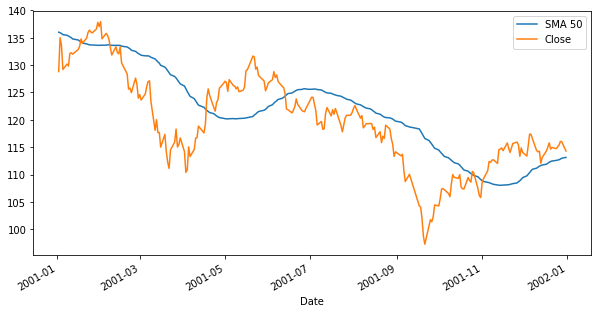

In [90]:
sma50 = tl.SMA(data['Close'].values, timeperiod=50)
data['SMA 50'] = sma50
data['Crosses down SMA 50'] = (C < data['SMA 50']) & (C > data['SMA 50']).shift()
data[['SMA 50', 'Close']]['2001'].plot(figsize=(10,5))
data.drop('SMA 50', axis=1, inplace=True)

In [91]:
data[data['Crosses down SMA 50']]['2001']

,Open,High,Low,Close,Volume,Weekday,Month,Last trading day of month,First trading day of month,End of Quarter,...,Closes high 50d U(10d),Closes high 50d S(1d),Closes high 50d S(2d),Closes high 50d S(3d),Closes high 50d S(5d),Intraday high 50d,Closes up SMA 200,Closes up SMA 10,Closes up SMA 10 S(1d),Crosses down SMA 50
Date,,,,,,,,,,,,,,,,,,,,,
2001-01-19,136.1875,136.1875,133.875,134.0156,7782500,Fri,1,False,False,False,...,False,False,False,False,False,False,False,True,True,True
2001-02-08,134.8000,135.4000,133.100,133.1200,5943300,Thu,2,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2001-06-14,124.1800,124.3000,121.750,122.0000,12603000,Thu,6,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2001-10-29,110.1600,110.5500,107.450,107.4500,18727500,Mon,10,False,False,False,...,False,False,False,False,False,False,False,False,True,True


# RSI

In [89]:
rsi2 = tl.RSI(C.values, timeperiod=2)

In [90]:
data['RSI2'] = rsi2
data['RSI 2d closes down 2'] = data['RSI2'] < 2
data['RSI 2d closes up 85'] = data['RSI2'] > 85
data['RSI 2d closes up 90'] = data['RSI2'] > 90
data['RSI 2d crosses over 99'] = (data['RSI2'] > 99) & (data['RSI2'] < 99).shift()
data['RSI 2d crosses down 5 S(1d)'] = (data['RSI2'] < 5).shift().fillna(False)
data.drop('RSI2', axis=1, inplace=True)

In [91]:
llen('RSI 2d crosses over 99')

35

In [92]:
llen('RSI 2d crosses down 5 S(1d)')

235

# ADX

In [93]:
data['ADX14'] = tl.ADX(H.values, L.values, C.values, timeperiod=14)
data['ADX 14d closes up 20'] = data['ADX14'] > 20
data.drop('ADX14', axis=1, inplace=True)

In [94]:
llen('ADX 14d closes up 20')

2538

# Change from previous days

In [93]:
data['Closes up 2pct 3d'] = C.pct_change(3) > 0.02

In [94]:
data['Closes up 2pct 1d'] = C.pct_change() > 0.02

In [96]:
data['Closes range down 1pct 1d'] = (C.pct_change() > -0.01) & data['Closes down 1d']

In [97]:
data[['Close', 'Closes up 2pct 3d']]['1999-03-24':'1999-03-29']

,Close,Closes up 2pct 3d
Date,,
1999-03-24,126.9062,False
1999-03-25,129.5000,False
1999-03-26,128.5625,False
1999-03-29,131.1562,True


In [99]:
data['Closes down 1.75pct 1d S(1d)'] = (C.pct_change() < -0.0175).shift().fillna(False)

In [100]:
data[['Close', 'Closes down 1.75pct 1d S(1d)']]['1999-03-18':'1999-03-24']

,Close,Closes down 1.75pct 1d S(1d)
Date,,
1999-03-18,132.2500,False
1999-03-19,129.6875,False
1999-03-22,129.9375,True
1999-03-23,126.1875,False
1999-03-24,126.9062,True


In [101]:
data['Closes up 5d'] = C > C.shift(5)
data['Closes up 20d'] = C > C.shift(20)

# GAP

In [103]:
data['Bullish'] = C > O

In [104]:
data['Unfulfilled gap up'] = L > C.shift()
data['Unfulfilled gap down'] = H < C.shift()

In [105]:
data['Gap down 1d'] = O < C.shift()

In [106]:
data['Gap up 1pct 1d'] = O > 1.01*C.shift()

In [107]:
data[['Gap up 1pct 1d', 'Close', 'Open']]['1999-03-30':'1999-04-06']

,Gap up 1pct 1d,Close,Open
Date,,,
1999-03-30,False,130.4687,129.9375
1999-03-31,False,128.3750,131.1562
1999-04-01,True,129.3437,129.6875
1999-04-05,True,132.4062,130.9375
1999-04-06,False,132.0937,132.1875


In [108]:
DR = H - L
data['Closes top 10pct'] = C > (H - DR*0.1)
data['Closes top 15pct'] = C > (H - DR*0.15)
data['Closes top 25pct'] = C > (H - DR*0.25)
data['Closes bottom 10pct'] = C < (L + DR*0.1)
data['Closes bottom 15pct'] = C < (L + DR*0.15)
data['Closes bottom 25pct'] = C < (L + DR*0.25)

In [109]:
data['Closes bottom 15pct'].value_counts()

False    4019
True      728
Name: Closes bottom 15pct, dtype: int64

In [110]:
data['Gap down in a row 5d'] = data['Gap down 1d'].rolling(5).mean() == 1

In [111]:
llen('Gap down in a row 5d')

44

In [112]:
data['Higher high 1d'] = H > H.shift()
data['Lower low 1d'] = L < L.shift()

In [113]:
data['Higher high S(1d)'] = data['Higher high 1d'].shift().fillna(False)
data['Lower low S(1d)'] = data['Lower low 1d'].shift().fillna(False)

In [114]:
data['Unfulfilled gap up S(1d)'] = data['Unfulfilled gap up'].shift().fillna(False)
data['Unfulfilled gap down S(1d)'] = data['Unfulfilled gap down'].shift().fillna(False)

In [115]:
data['Unfulfilled gap up in a row 3d'] = data['Unfulfilled gap up'].rolling(3).mean() == 1

In [116]:
llen('Unfulfilled gap up in a row 3d')

19

In [117]:
data['Unfulfilled gap down in a row 2d'] = data['Unfulfilled gap down'].rolling(2).mean() == 1

In [118]:
llen('Unfulfilled gap down in a row 2d')

73

In [118]:
data['Gap down 0.5pct'] = O < 0.995*C.shift()

In [119]:
data['Gap down 1d S(1d)'] = data['Gap down 1d'].shift().fillna(False)
data['Closes down 1d S(1d)'] = data['Closes down 1d'].shift().fillna(False)

# Inside

In [119]:
data['Inside'] = (L > L.shift()) & (H < H.shift()) # smaller candle
data['Outside'] = (L < L.shift()) & H > (H.shift()) # bigger candle

In [121]:
data['Inside S(1d)'] = data['Inside'].shift().fillna(False)
data['Outside S(1d)'] = data['Outside'].shift().fillna(False)

In [122]:
data['Closes down 1pct 1d S(5d)'] = (C.pct_change() < -0.01).shift(5).fillna(False)

In [123]:
data['Closes up open 1pct'] = C > O*1.01

In [124]:
data['Closes down 3d'] = C < C.shift(3)
data['Closes down 7d'] = C < C.shift(7)

In [125]:
hh10 = H.rolling(10).max()
ll10 = L.rolling(10).min()
data['Closes in top 10pct 10d'] = C > (hh10 - (hh10 - ll10)*0.1)

In [126]:
data['Closes up 0.25pct 1d'] = C < 1.0025*(C.shift())

In [127]:
data['Lowest range 10d'] = DR.rolling(10).min().fillna(0)
data['Lowest range 60d'] = DR.rolling(60).min().fillna(0)

In [128]:
data['Highest range 10d S(1d)'] = DR.rolling(10).max().shift().fillna(False)

In [129]:
data['Opens down low 1d'] = O < L.shift()
data['Closes up high 1d'] = C > H.shift()

In [130]:
data['Falls 1.5X ATR 20d S(1d)'] = (C.shift() - C) > 1.5*tl.ATR(H.values, L.values, C.values, timeperiod=20)

In [131]:
llen('Falls 1.5X ATR 20d S(1d)')

103

In [132]:
change = C.pct_change()
data['Worst 1d decline 10d'] = change == change.rolling(10).min()

In [133]:
data['Closes bottom 25pct in a row 4d'] = data['Closes bottom 25pct'].rolling(4).mean() == 1
llen('Closes bottom 25pct in a row 4d')

21

# Strikes up

In [134]:
data['Closes up SMA5 in a row 10d'] = (C > tl.SMA(C.values, timeperiod=5)).rolling(10).mean() == 1

In [135]:
llen('Closes up SMA5 in a row 10d')

207

In [136]:
data['Rally in 10d'] = ((C == C.rolling(50).min()).rolling(10).sum() > 0) & (C == C.rolling(50).max())

In [137]:
data[data['Rally in 10d']]

,Open,High,Low,Close,Volume,Weekday,Month,Last trading day of month,First trading day of month,End of Quarter,...,Lowest range 10d,Lowest range 60d,Highest range 10d S(1d),Opens down low 1d,Closes up high 1d,Falls 1.5X ATR 20d S(1d),Worst 1d decline 10d,Closes bottom 25pct in a row 4d,Closes up SMA5 in a row 10d,Rally in 10d
Date,,,,,,,,,,,,,,,,,,,,,
2011-10-14,121.86,122.60,121.23,122.56,43756388,Fri,10,False,False,False,...,1.28,0.93,5.15,False,True,False,False,False,False,True
2014-08-20,198.12,199.16,198.08,198.92,72762544,Wed,8,False,False,False,...,0.76,0.40,2.58,False,True,False,False,False,False,True
2016-07-08,211.05,212.94,210.78,212.65,133970976,Fri,7,False,False,False,...,1.20,0.74,8.13,False,True,False,False,False,False,True
2016-07-11,213.19,214.07,212.95,213.40,73633936,Mon,7,False,False,False,...,1.12,0.74,8.13,False,True,False,False,False,False,True
2016-11-17,218.05,219.06,217.92,218.99,69797192,Thu,11,False,False,False,...,0.72,0.72,4.76,False,True,False,False,False,False,True


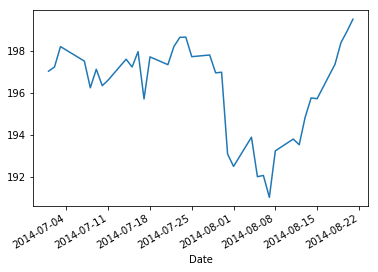

In [138]:
data['2014-07':'2014-08-21']['Close'].plot()

In [139]:
data['Rate of decline slowed in a row 2d'] = change.rolling(2).apply(lambda x: (x[0] < 0) and (x[1] < 0) and (x[1] > x[0])).fillna(0) == 1

In [140]:
data['Biggest decline 4d'] = (change.rolling(4).min() == change) & (change < 0)

In [141]:
data[['Biggest decline 4d', 'Daily return']]['1999-03-15':'1999-03-23']

,Biggest decline 4d,Daily return
Date,,
1999-03-15,False,1.425082
1999-03-16,False,-0.381043
1999-03-17,False,-0.430313
1999-03-18,False,1.608682
1999-03-19,True,-1.937618
1999-03-22,False,0.192771
1999-03-23,True,-2.886003


In [142]:
data['Lower HLC in a row 3d'] = ((H < H.shift()) & (L < L.shift()) & (C < C.shift())).rolling(3).mean() == 1

In [143]:
data['1999-07-19':'1999-07-25'][['High', 'Low', 'Close', 'Lower HLC in a row 3d']]

,High,Low,Close,Lower HLC in a row 3d
Date,,,,
1999-07-19,142.2500,140.5625,140.8750,False
1999-07-20,140.4062,137.5312,137.9843,False
1999-07-21,138.9062,137.3125,137.8281,False
1999-07-22,138.0000,135.4687,136.0156,True
1999-07-23,137.0000,135.1250,135.7500,True


In [144]:
data['Closes down 1pct in a row 3d'] = (change < -0.01).rolling(3).mean() == 1

In [145]:
data['2001-02-14':'2001-02-21'][['Daily return', 'Closes down 1pct in a row 3d']]

,Daily return,Closes down 1pct in a row 3d
Date,,
2001-02-14,-0.151217,False
2001-02-15,0.969256,False
2001-02-16,-2.204890,False
2001-02-20,-1.541411,False
2001-02-21,-2.157489,True


In [146]:
data.drop(['Open', 'High', 'Close', 'Low', 'Volume'], axis=1, inplace=True)

In [147]:
for c in data.columns:
    print(c, '==>', data[c].iloc[0])

Weekday ==> Wed
Month ==> 3
Last trading day of month ==> False
First trading day of month ==> False
End of Quarter ==> False
Closes down 1d ==> False
Closes up in a row 2d ==> False
Closes up in a row 3d ==> False
Closes up in a row 4d ==> False
Closes up in a row 5d ==> False
Closes up in a row 5d S(1d) ==> False
Closes down in a row 2d ==> False
Closes down in a row 3d ==> False
Closes down in a row 4d ==> False
Closes down in a row 5d ==> False
Day ==> 10
Daily return ==> 0.0
Lowest volume 5d ==> False
Daily return 5d ==> 0.0
OPEX week ==> False
Tomorrow is OPEX Friday ==> False
Today is OPEX Friday ==> False
Before OPEX week ==> True
Highest closing price of the month ==> False
Daily return S(1d) ==> 0.0
First trading day of month S(1d) ==> False
Thursday before Labor Day ==> False
Friday before Labor Day ==> False
Friday before Columbus Day ==> False
Thursday before Pres Day ==> False
Closes high 4d ==> False
Closes low 5d ==> False
Closes low 5d S(1d) ==> False
Closes low 5d U(1

In [148]:
data[data.isna().any(axis=1)]

,Weekday,Month,Last trading day of month,First trading day of month,End of Quarter,Closes down 1d,Closes up in a row 2d,Closes up in a row 3d,Closes up in a row 4d,Closes up in a row 5d,...,Closes up high 1d,Falls 1.5X ATR 20d S(1d),Worst 1d decline 10d,Closes bottom 25pct in a row 4d,Closes up SMA5 in a row 10d,Rally in 10d,Rate of decline slowed in a row 2d,Biggest decline 4d,Lower HLC in a row 3d,Closes down 1pct in a row 3d
Date,,,,,,,,,,,,,,,,,,,,,


In [149]:
data.to_csv('SPY_all_features.csv')